In [1]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

In [2]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
prices = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sales = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [3]:
# optuna: a package recommended for model optimazation and selection

#### Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [4]:
sales.shape

(30490, 1947)

In [5]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [6]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30489,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)
print(sales_bd, calendar_bd, prices_bd)

454.5 0.2 208.8


In [9]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [10]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)
print(sales_bd, calendar_bd, prices_bd)

97.1 0.1 45.8


In [11]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
             , var_name='d', value_name='sold').dropna()

In [12]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [13]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [14]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

In [15]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN


In [16]:
df[df.store_id == 'CA_2'].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
3049,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3050,HOBBIES_1_002_CA_2_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3051,HOBBIES_1_003_CA_2_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3052,HOBBIES_1_004_CA_2_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_2,CA,d_1,6,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,4.339844,26.039062
3053,HOBBIES_1_005_CA_2_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN


# Feature Engineering

In [17]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [18]:
d_store_id

{0: 'CA_1',
 1: 'CA_2',
 2: 'CA_3',
 3: 'CA_4',
 4: 'TX_1',
 5: 'TX_2',
 6: 'TX_3',
 7: 'WI_1',
 8: 'WI_2',
 9: 'WI_3'}

In [19]:
#convert date d_1969 into int
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)

In [20]:
#replace categorical values with codes
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

In [21]:
df[df.store_id == 1].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
3049,14371,1437,3,1,1,0,1,0,2011-01-29,11101,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
3050,14381,1438,3,1,1,0,1,0,2011-01-29,11101,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
3051,14391,1439,3,1,1,0,1,0,2011-01-29,11101,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN
3052,14401,1440,3,1,1,0,1,6,2011-01-29,11101,...,2011,-1,-1,-1,-1,0,0,0,4.339844,26.039062
3053,14411,1441,3,1,1,0,1,0,2011-01-29,11101,...,2011,-1,-1,-1,-1,0,0,0,NaN,NaN


### Introduce lags

In [22]:
# Introduce lags
# creating a few cols
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [23]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,snap_WI,sell_price,revenue,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_6,sold_lag_12,sold_lag_24,sold_lag_36
0,14370,1437,3,1,0,0,1,0,2011-01-29,11101,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14380,1438,3,1,0,0,1,0,2011-01-29,11101,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14390,1439,3,1,0,0,1,0,2011-01-29,11101,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14400,1440,3,1,0,0,1,0,2011-01-29,11101,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14410,1441,3,1,0,0,1,0,2011-01-29,11101,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Means

In [24]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

### Rolling Windows

In [25]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

### Expanding Windows

In [26]:
# Cumulative?

In [27]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

### Trends

In [28]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

### Save the Data

In [29]:
df = df[df['d']>=36]

In [30]:
df.drop('date',axis=1,inplace=True)

In [31]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
1067150,14370,1437,3,1,0,0,36,0,11106,2,...,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,0.0,0.0,-0.321533
1067151,14380,1438,3,1,0,0,36,0,11106,2,...,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,0.0,0.0,-0.253906
1067152,14390,1439,3,1,0,0,36,0,11106,2,...,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.0,0.0,-0.156982
1067153,14400,1440,3,1,0,0,36,0,11106,2,...,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,0.0,0.0,-1.694336
1067154,14410,1441,3,1,0,0,36,0,11106,2,...,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.0,0.0,-0.958984


In [32]:
df.shape

(58967660, 44)

In [33]:
df.to_pickle('lgbm_data_fe.pkl')
del df
gc.collect();

In [2]:
data = pd.read_pickle('lgbm_data_fe.pkl')
data.shape

(58967660, 44)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

In [3]:
'''
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']
'''

In [11]:
pd.set_option('display.max_columns', 500)

In [12]:
#X_test
df = data[data['store_id']==0]
df[df['d']>=1942].drop('sold',axis=1)

,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_6,sold_lag_12,sold_lag_24,sold_lag_36,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
59181090,14370,1437,3,1,0,0,1942,11617,1,3,5,2016,-1,-1,-1,-1,0,0,0,8.382812,0.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.216553,1.21582,1.304688,0.561035,0.695801,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,1.000000,0.325928,-0.321533
59181091,14380,1438,3,1,0,0,1942,11617,1,3,5,2016,-1,-1,-1,-1,0,0,0,3.970703,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.259766,1.21582,1.304688,0.561035,0.695801,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,0.142822,0.257568,-0.253906
59181092,14390,1439,3,1,0,0,1942,11617,1,3,5,2016,-1,-1,-1,-1,0,0,0,2.970703,0.0,1.0,0.0,3.0,0.0,1.0,0.0,2.0,0.076660,1.21582,1.304688,0.561035,0.695801,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.856934,0.159058,-0.156982
59181093,14400,1440,3,1,0,0,1942,11617,1,3,5,2016,-1,-1,-1,-1,0,0,0,4.640625,0.0,6.0,2.0,0.0,0.0,1.0,4.0,5.0,2.011719,1.21582,1.304688,0.561035,0.695801,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,1.713867,1.718750,-1.694336
59181094,14410,1441,3,1,0,0,1942,11617,1,3,5,2016,-1,-1,-1,-1,0,0,0,2.880859,0.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,0.755371,1.21582,1.304688,0.561035,0.695801,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,0.571289,0.972168,-0.958984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60007364,14320,1432,2,0,0,0,1969,11621,3,2,6,2016,16,3,2,0,0,0,0,2.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797852,1.21582,1.304688,1.623047,2.033203,2.033203,0.579590,0.797852,0.797852,1.304688,1.933594,2.464844,0.000000,0.579590,-0.579590
60007365,14330,1433,2,0,0,0,1969,11621,3,2,6,2016,16,3,2,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.430176,1.21582,1.304688,1.623047,2.033203,2.033203,0.707520,0.430176,0.430176,1.304688,1.933594,2.464844,0.000000,0.707520,-0.707520
60007366,14340,1434,2,0,0,0,1969,11621,3,2,6,2016,16,3,2,0,0,0,0,3.980469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.704102,1.21582,1.304688,1.623047,2.033203,2.033203,0.947754,0.704102,0.704102,1.304688,1.933594,2.464844,0.000000,0.947754,-0.947754
60007367,14350,1435,2,0,0,0,1969,11621,3,2,6,2016,16,3,2,0,0,0,0,1.280273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.637207,1.21582,1.304688,1.623047,2.033203,2.033203,0.909180,0.637207,0.637207,1.304688,1.933594,2.464844,0.000000,0.909180,-0.909180


In [4]:
test

,id,d,sold
59181090,14370,1942,0
59181091,14380,1942,0
59181092,14390,1942,0
59181093,14400,1942,0
59181094,14410,1942,0
...,...,...,...
60034805,14329,1969,0
60034806,14339,1969,0
60034807,14349,1969,0
60034808,14359,1969,0


In [5]:
valid

,id,d,sold
58327370,14370,1914,0
58327371,14380,1914,0
58327372,14390,1914,0
58327373,14400,1914,0
58327374,14410,1914,1
...,...,...,...
59181085,14329,1941,1
59181086,14339,1941,0
59181087,14349,1941,2
59181088,14359,1941,0


In [13]:
#X_Valid
df = data[data['store_id']==0]
df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1)

,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_6,sold_lag_12,sold_lag_24,sold_lag_36,iteam_sold_avg,state_sold_avg,store_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,store_item_sold_avg,cat_item_sold_avg,dept_item_sold_avg,state_store_sold_avg,state_store_cat_sold_avg,store_cat_dept_sold_avg,rolling_sold_mean,expanding_sold_mean,selling_trend
58327370,14370,1437,3,1,0,0,1914,11613,1,3,4,2016,-1,-1,-1,-1,0,0,0,8.382812,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.216553,1.21582,1.304688,0.561035,0.695801,0.695801,0.321533,0.216553,0.216553,1.304688,0.801758,1.020508,1.000000,0.313477,-0.321533
58327371,14380,1438,3,1,0,0,1914,11613,1,3,4,2016,-1,-1,-1,-1,0,0,0,3.970703,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.259766,1.21582,1.304688,0.561035,0.695801,0.695801,0.253906,0.259766,0.259766,1.304688,0.801758,1.020508,0.142822,0.257568,-0.253906
58327372,14390,1439,3,1,0,0,1914,11613,1,3,4,2016,-1,-1,-1,-1,0,0,0,2.970703,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.076660,1.21582,1.304688,0.561035,0.695801,0.695801,0.156982,0.076660,0.076660,1.304688,0.801758,1.020508,0.714355,0.150513,-0.156982
58327373,14400,1440,3,1,0,0,1914,11613,1,3,4,2016,-1,-1,-1,-1,0,0,0,4.640625,0.000000,2.0,7.0,3.0,1.0,3.0,3.0,1.0,2.011719,1.21582,1.304688,0.561035,0.695801,0.695801,1.694336,2.011719,2.011719,1.304688,0.801758,1.020508,2.000000,1.717773,-1.694336
58327374,14410,1441,3,1,0,0,1914,11613,1,3,4,2016,-1,-1,-1,-1,0,0,0,2.880859,2.880859,4.0,2.0,2.0,1.0,1.0,0.0,2.0,0.755371,1.21582,1.304688,0.561035,0.695801,0.695801,0.958984,0.755371,0.755371,1.304688,0.801758,1.020508,1.857422,0.966797,0.041016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59153644,14320,1432,2,0,0,0,1941,11617,3,2,5,2016,-1,-1,-1,-1,0,0,0,2.980469,5.960938,4.0,3.0,4.0,1.0,2.0,1.0,0.0,0.797852,1.21582,1.304688,1.623047,2.033203,2.033203,0.579590,0.797852,0.797852,1.304688,1.933594,2.464844,2.285156,0.587891,1.419922
59153645,14330,1433,2,0,0,0,1941,11617,3,2,5,2016,-1,-1,-1,-1,0,0,0,2.480469,0.000000,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.430176,1.21582,1.304688,1.623047,2.033203,2.033203,0.707520,0.430176,0.430176,1.304688,1.933594,2.464844,0.856934,0.717773,-0.707520
59153646,14340,1434,2,0,0,0,1941,11617,3,2,5,2016,-1,-1,-1,-1,0,0,0,3.980469,3.980469,0.0,3.0,0.0,2.0,1.0,1.0,2.0,0.704102,1.21582,1.304688,1.623047,2.033203,2.033203,0.947754,0.704102,0.704102,1.304688,1.933594,2.464844,1.142578,0.961426,0.052246
59153647,14350,1435,2,0,0,0,1941,11617,3,2,5,2016,-1,-1,-1,-1,0,0,0,1.280273,1.280273,2.0,1.0,0.0,1.0,3.0,1.0,0.0,0.637207,1.21582,1.304688,1.623047,2.033203,2.033203,0.909180,0.637207,0.637207,1.304688,1.933594,2.464844,1.571289,0.922363,0.090820


In [111]:
# move everything back 28 days
valid = data[(data['d']>=1886) & (data['d']<1914)][['id','d','sold']]
test = data[data['d']>=1914][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

In [113]:
#Get the store ids
#1886 1914
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1886].drop('sold',axis=1), df[df['d']<1886]['sold']
    X_valid, y_valid = df[(df['d']>=1886) & (df['d']<1914)].drop('sold',axis=1), df[(df['d']>=1886) & (df['d']<1914)]['sold']
    X_test = df[df['d']>=1914].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
[20]	training's rmse: 0.660233	training's l2: 0.435907	valid_1's rmse: 0.351402	valid_1's l2: 0.123483
[40]	training's rmse: 0.618901	training's l2: 0.383038	valid_1's rmse: 0.329774	valid_1's l2: 0.108751
[60]	training's rmse: 0.594373	training's l2: 0.35328	valid_1's rmse: 0.316632	valid_1's l2: 0.100256
[80]	training's rmse: 0.578741	training's l2: 0.334941	valid_1's rmse: 0.304705	valid_1's l2: 0.092845
[100]	training's rmse: 0.563724	training's l2: 0.317784	valid_1's rmse: 0.298641	valid_1's l2: 0.0891865
[120]	training's rmse: 0.553021	training's l2: 0.305832	valid_1's rmse: 0.292512	valid_1's l2: 0.085563
[140]	training's rmse: 0.545304	training's l2: 0.297357	valid_1's rmse: 0.289372	valid_1's l2: 0.083736
[160]	training's rmse: 0.53635	training's l2: 0.287671	valid_1's rmse: 0.285087	valid_1's l2: 0.0812746
[180]	training's rmse: 0.528532	training's l2: 0.279347	valid_1's rmse: 0.288178	valid_1's l2: 0.0830464
*****Prediction for Store: CA_

[220]	training's rmse: 0.401054	training's l2: 0.160844	valid_1's rmse: 0.353668	valid_1's l2: 0.125081


In [114]:
valid_preds.shape

(853720,)

In [115]:
eval_preds.shape

(1707440,)

In [ ]:
#X_test = df[df['d']>=1942].drop('sold',axis=1)
#eval_preds[X_test.index] = model.predict(X_test)
#eval_preds is the prediction of  X_test
#1942 - 1969

In [116]:
ground_truth = sales[['id']+['d_' + str(i) for i in range(1886,1914)]]
ground_truth['id']=pd.read_csv(f'{m5_input_path}/sales_train_validation.csv').id
ground_truth.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

In [117]:
ground_truth

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1,0,0,0,0,0,1,0,4,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,1,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,3,1,2,1,3,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,1,0,4,4,0,1,4,0,1,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,1,1,2,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,1,0,0,0,0,1,1,2,1,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,3,0,0,0,0,0,1,1,2,...,0,0,1,0,0,1,0,3,1,3


In [120]:
test['sold'] = eval_preds
#valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]

In [121]:
test

,id,d,sold
58327370,14370,1914,-0.009614
58327371,14380,1914,0.000218
58327372,14390,1914,0.000570
58327373,14400,1914,0.000906
58327374,14410,1914,1.004564
...,...,...,...
60034805,14329,1969,-0.000591
60034806,14339,1969,0.003024
60034807,14349,1969,-0.000777
60034808,14359,1969,0.001758


In [126]:
validation = test[['id','d','sold']]
validation

,id,d,sold
58327370,14370,1914,-0.009614
58327371,14380,1914,0.000218
58327372,14390,1914,0.000570
58327373,14400,1914,0.000906
58327374,14410,1914,1.004564
...,...,...,...
60034805,14329,1969,-0.000591
60034806,14339,1969,0.003024
60034807,14349,1969,-0.000777
60034808,14359,1969,0.001758


In [127]:
validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
validation

d,id,1914,1915,1916,1917,1918,1919,1920,1921,1922,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
0,0,1.978239,0.001062,0.001062,0.001062,0.001062,0.987130,0.987130,0.001062,5.964138,...,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062
1,1,0.008084,2.950751,0.008084,0.008084,0.008084,0.998054,4.016992,0.008084,0.008084,...,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084
2,2,1.107503,0.012806,1.107503,0.012806,7.780520,1.139253,0.000252,0.012806,1.146063,...,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806
3,3,0.000402,0.997467,0.000402,0.000402,0.000402,0.000402,0.997467,0.000402,0.000402,...,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402
4,4,0.002631,0.002631,1.006757,0.002631,1.006757,0.002631,1.006757,1.006757,1.006757,...,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,30485,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,1.002729,-0.002048,...,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048
30486,30486,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,1.030543,-0.002368,-0.002368,...,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368
30487,30487,1.030353,-0.001462,-0.001462,1.030353,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,...,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462
30488,30488,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,...,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902


In [130]:
validation.columns=['id'] + ['F' + str(i + 1) for i in range(56)]

In [131]:
validation.id = validation.id.map(d_id).str.replace('evaluation','validation')
validation

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56
0,FOODS_1_001_CA_1_validation,1.978239,0.001062,0.001062,0.001062,0.001062,0.987130,0.987130,0.001062,5.964138,...,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062,0.001062
1,FOODS_1_001_CA_2_validation,0.008084,2.950751,0.008084,0.008084,0.008084,0.998054,4.016992,0.008084,0.008084,...,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084,0.008084
2,FOODS_1_001_CA_3_validation,1.107503,0.012806,1.107503,0.012806,7.780520,1.139253,0.000252,0.012806,1.146063,...,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806,0.012806
3,FOODS_1_001_CA_4_validation,0.000402,0.997467,0.000402,0.000402,0.000402,0.000402,0.997467,0.000402,0.000402,...,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402,0.000402
4,FOODS_1_001_TX_1_validation,0.002631,0.002631,1.006757,0.002631,1.006757,0.002631,1.006757,1.006757,1.006757,...,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631,0.002631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,1.002729,-0.002048,...,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048,-0.002048
30486,HOUSEHOLD_2_516_TX_3_validation,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,1.030543,-0.002368,-0.002368,...,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368,-0.002368
30487,HOUSEHOLD_2_516_WI_1_validation,1.030353,-0.001462,-0.001462,1.030353,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,...,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462
30488,HOUSEHOLD_2_516_WI_2_validation,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,...,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902,-0.001902


In [132]:
validation.shape

(30490, 57)

In [152]:
item_id = 'FOODS_2_001_TX_1_validation'

In [153]:
preds = validation[validation.id == item_id].set_index('id').T

<AxesSubplot:>

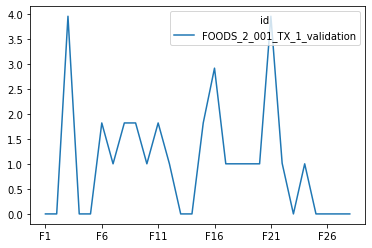

In [154]:
preds.iloc[:28,:].plot()

In [155]:
actuals = ground_truth[ground_truth.id == item_id].set_index('id').T

<AxesSubplot:>

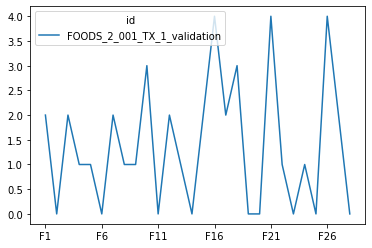

In [156]:
actuals.plot()

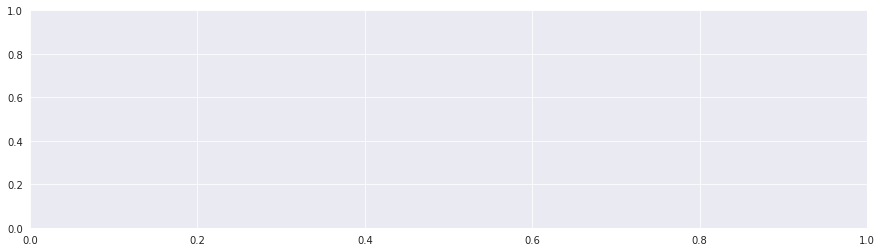

In [50]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1,figsize=(15,4))
'''
ax1.plot(indexes, preds, color='red', label='forecast')
ax1.plot(indexes, trues, color='blue', label='ground truth')
ax1.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax1.legend()

start = 10
ax2.plot(list(range(start,start+30)), actuals_np[start], color='blue', label='input')
ax2.plot(list(range(start+30, start+60)), predictions_np[start], color='red', label='forecast')
ax2.plot(list(range(start+30, start+60)), actuals_np[start+30], color='cornflowerblue', label='ground truth')
ax2.set_title(f"Individual example forecast - N-BEATS")
ax2.legend(loc='upper left')
'''
plt.show()

In [105]:
store = 1
df = data[data['store_id']==store]

In [111]:
data.shape

(5896766, 43)

In [ ]:
    
    #Split the data
X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )

print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
valid_preds[X_valid.index] = model.predict(X_valid)
eval_preds[X_test.index] = model.predict(X_test)
filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
joblib.dump(model, filename)
del model, X_train, y_train, X_valid, y_valid
gc.collect()